# 2022年7月22日20:13:17

# 1. 物理模型

二维热扩散问题，控制方程如下：
$$k_x\frac{\partial^2T}{\partial x^2}+k_y\frac{\partial^2T}{\partial y^2}+q=0$$

边界条件如下：
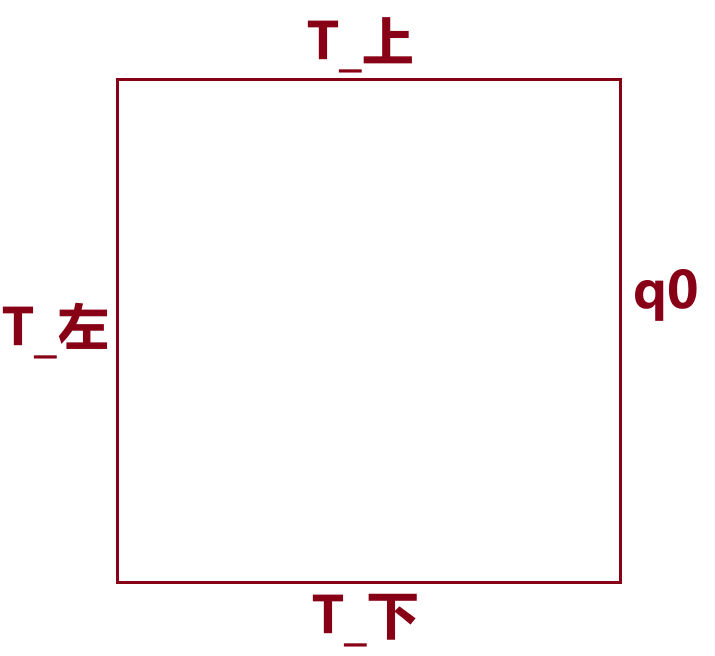

利用伽辽金方法可得到：

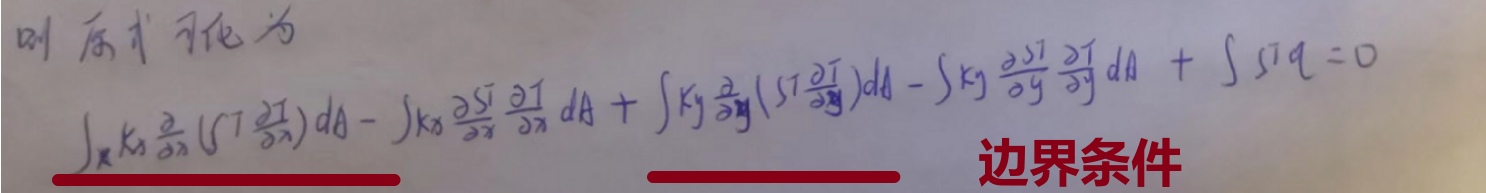

# 2. 矩阵形式

## 2.1 单元刚度矩阵

单元刚度矩阵如下：

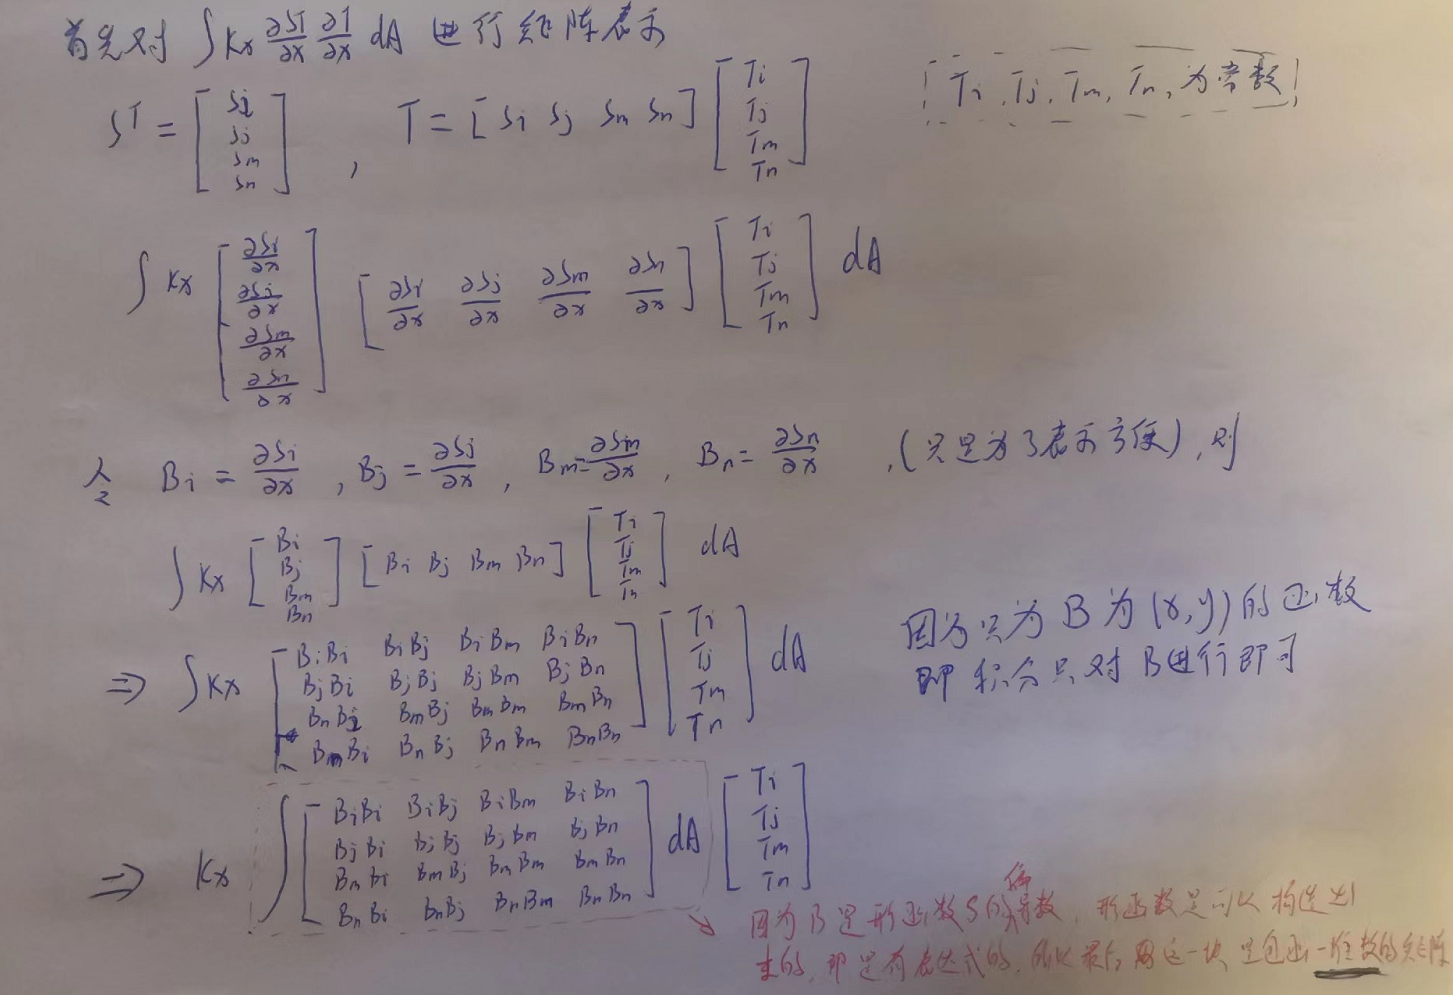

## 2.2 单元源项矩阵

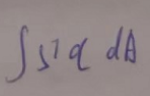

## 2.3 Neumman边界条件矩阵

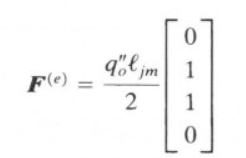

图片中$q''_o$表示边界热通量，$l_{jm}$表示$jm$方向单元格长度，即$y_{i+1}-y_i$

# 3. 组装矩阵

总的矩阵形式如下：
$$KT=F^q+F^{q_0}$$

其中$K$为刚度矩阵，$T$为待求矩阵，$F^q$为热源矩阵，$F^{q_0}$为边界通量矩阵

注意：**最后还需要加一个Dirichlet边界条件**

## 3.1 形函数

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import leggauss

利用一维线性形函数来组合构建二维线性形函数

In [2]:
# 一维1次形函数
# f1l: 1 D, left f of 1 order 
def f1l1(x,xl,xr):
    return (x-xr)/(xl-xr)

# f1r: 1 D, righ f of 1 order 
def f1r1(x,xl,xr):
    return (x-xl)/(xr-xl)

In [4]:
# 定义一维一次函数的导数
def df1l1(x,xl,xr):
    return 1/(xl-xr)

def df1r1(x,xl,xr):
    return 1/(xr-xl)

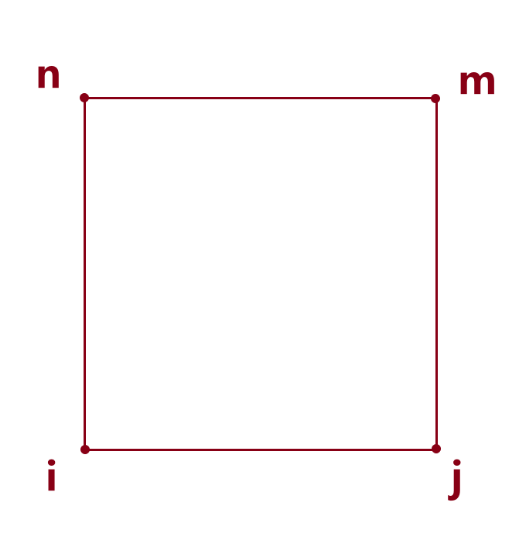

In [5]:
# 二维形函数
# f_(i,j,m,n)表示在该点的值为1
def fi(y,x,yd,yu,xl,xr):
    return f1l1(y,yd,yu)*f1l1(x,xl,xr)

def fj(y,x,yd,yu,xl,xr):
    return f1l1(y,yd,yu)*f1r1(x,xl,xr)

def fm(y,x,yd,yu,xl,xr):
    return f1r1(y,yd,yu)*f1r1(x,xl,xr)

def fn(y,x,yd,yu,xl,xr):
    return f1r1(y,yd,yu)*f1l1(x,xl,xr)

In [6]:
# 定义二维形函数的偏导数
# x
def dxfi(y,x,yd,yu,xl,xr):
    return f1l1(y,yd,yu)*df1l1(x,xl,xr)

def dxfj(y,x,yd,yu,xl,xr):
    return f1l1(y,yd,yu)*df1r1(x,xl,xr)

def dxfm(y,x,yd,yu,xl,xr):
    return f1r1(y,yd,yu)*df1r1(x,xl,xr)

def dxfn(y,x,yd,yu,xl,xr):
    return f1r1(y,yd,yu)*df1l1(x,xl,xr)

# y
def dyfi(y,x,yd,yu,xl,xr):
    return df1l1(y,yd,yu)*f1l1(x,xl,xr)

def dyfj(y,x,yd,yu,xl,xr):
    return df1l1(y,yd,yu)*f1r1(x,xl,xr)

def dyfm(y,x,yd,yu,xl,xr):
    return df1r1(y,yd,yu)*f1r1(x,xl,xr)

def dyfn(y,x,yd,yu,xl,xr):
    return df1r1(y,yd,yu)*f1l1(x,xl,xr)

## 3.2 定义数值积分函数

In [11]:
# 定义二维高斯-勒让德积分
def leg_gau_2d(f,n,xa,xb,ya,yb):
    x,w=leggauss(n)
    # x=(xb-xa)xi/2+(xb+xa)/2
    # y=(yb-ya)eta/2+(yb+ya)/2
    # dx=(xb-xa)/2 dxi
    # dy=(yb-ya)/2 deta
    summ=0
    for i in range(len(x)):
        # i 代表x,用a表示
        a=(xb-xa)*x[i]/2+(xb+xa)/2
        for j in range(len(x)):
            # j 代表y，用b表示
            b=(yb-ya)*x[j]/2+(yb+ya)/2
            summ+=w[i]*w[j]*f(a,b)
    
    return (xb-xa)/2*(yb-ya)/2*summ

## 3.3 设置单元

In [35]:
# 设置单元以及节点坐标
n_e_x=50 # number of elements in x 
n_e_y=50 # number of elements in y

n_n_x=n_e_x+1 # number of nodes in x
n_n_y=n_e_y+1 # number of nodes in y
x=np.linspace(0,1,n_n_x)
y=np.linspace(0,1,n_n_y)

## 3.4 设置传热相关参数

In [36]:
kx=1    # x方向热导率
ky=1    # y方向热导率

q=80    # 面热源
q0=50   # 右边界通量
T_u=30  # 上边界温度
T_d=5   # 下边界温度
T_l=100 # 左边界温度

## 3.5 单元刚度矩阵

In [37]:
# 根据公式求单元刚度矩阵
# 这里只涉及矩阵，没有把前面的参数kx和ky放进去

# x
dx=[dxfi,dxfj,dxfm,dxfn]
Kx=np.zeros((4,4))
y0,y1=y[0],y[1]
x0,x1=x[0],x[1]
for i in range(len(dx)):
    for j in range(len(dx)):
        dfdf=lambda y,x:dx[i](y,x,y0,y1,x0,x1)*dx[j](y,x,y0,y1,x0,x1)
        Kx[i,j]=leg_gau_2d(dfdf,3,y0,y1,x0,x1)
Kx

array([[ 0.33333333, -0.33333333, -0.16666667,  0.16666667],
       [-0.33333333,  0.33333333,  0.16666667, -0.16666667],
       [-0.16666667,  0.16666667,  0.33333333, -0.33333333],
       [ 0.16666667, -0.16666667, -0.33333333,  0.33333333]])

In [38]:
# y
dy=[dyfi,dyfj,dyfm,dyfn]
Ky=np.zeros((4,4))
y0,y1=y[0],y[1]
x0,x1=x[0],x[1]
for i in range(len(dy)):
    for j in range(len(dy)):
        dfdf=lambda y,x:dy[i](y,x,y0,y1,x0,x1)*dy[j](y,x,y0,y1,x0,x1)
        Ky[i,j]=leg_gau_2d(dfdf,3,y0,y1,x0,x1)
Ky

array([[ 0.33333333,  0.16666667, -0.16666667, -0.33333333],
       [ 0.16666667,  0.33333333, -0.33333333, -0.16666667],
       [-0.16666667, -0.33333333,  0.33333333,  0.16666667],
       [-0.33333333, -0.16666667,  0.16666667,  0.33333333]])

In [39]:
Ke=kx*Kx+ky*Ky
Ke

array([[ 0.66666667, -0.16666667, -0.33333333, -0.16666667],
       [-0.16666667,  0.66666667, -0.16666667, -0.33333333],
       [-0.33333333, -0.16666667,  0.66666667, -0.16666667],
       [-0.16666667, -0.33333333, -0.16666667,  0.66666667]])

## 3.6 组装刚度矩阵

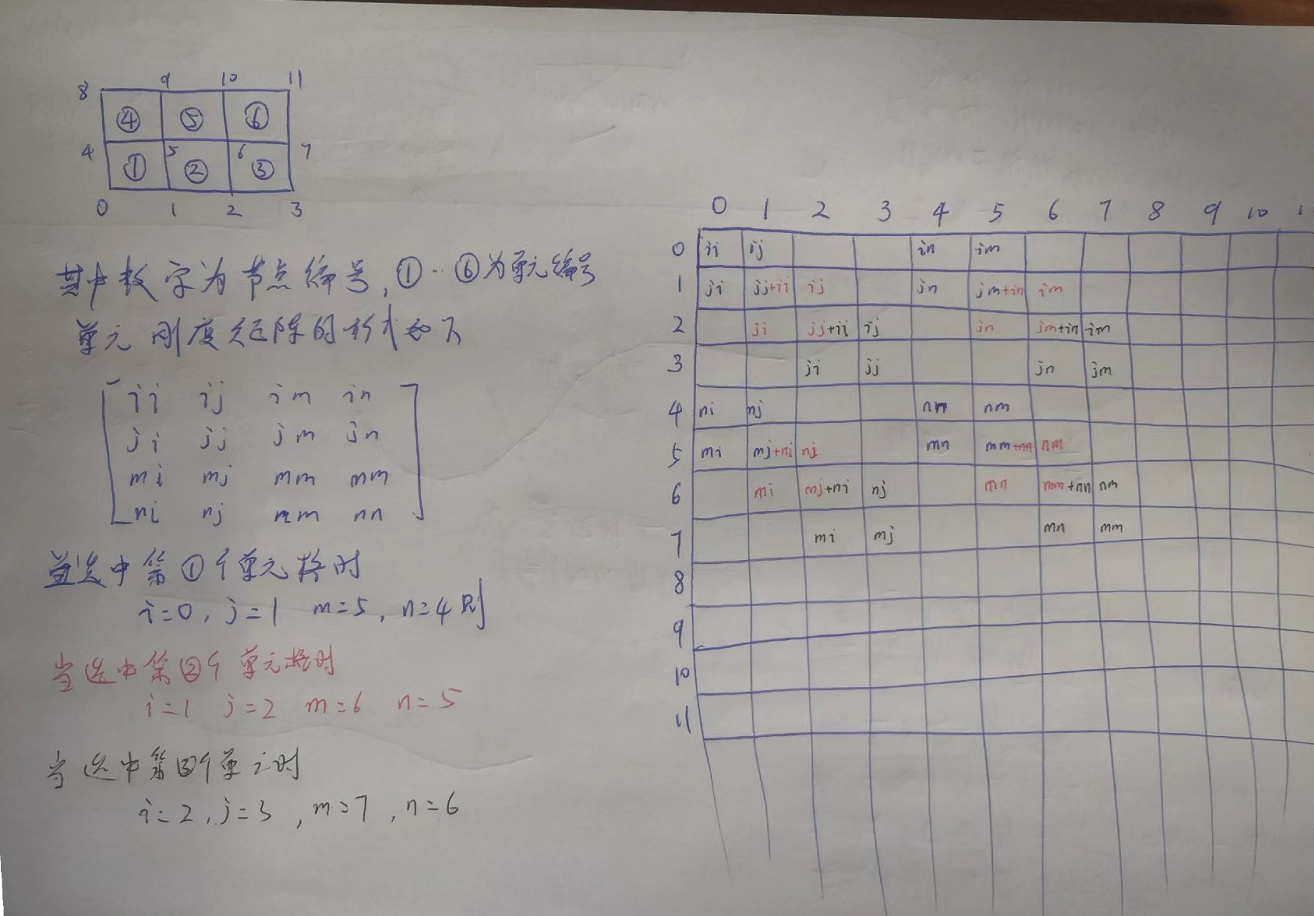

In [40]:
n_n=n_n_x*n_n_y  # 总节点个数; number of nodes
K=np.zeros((n_n,n_n))

for jy in range(n_e_y):
    for ix in range(n_e_x):
        # 不同单元中的i,j,m,n
        i=jy*n_n_x+ix
        j=i+1
        m=j+n_n_x
        n=m-1
        Kindex=[i,j,m,n]
        for ii in range(len(Kindex)):
            K[Kindex[ii],Kindex]+=Ke[ii]

## 3.7 源项单元矩阵

In [41]:
f=[fi,fj,fm,fn]
Fe=np.zeros(4)
for i in range(len(f)):
    ff=lambda y,x:f[i](y,x,y0,y1,x0,x1)
    Fe[i]=leg_gau_2d(ff,3,y0,y1,x0,x1)
    
Fe=q*Fe

## 3.8 组装源项矩阵

In [42]:
F=np.zeros(n_n)

for jy in range(n_e_y):
    for ix in range(n_e_x):
        # 不同单元中的i,j,m,n
        i=jy*n_n_x+ix
        j=i+1
        m=j+n_n_x
        n=m-1
        Findex=[i,j,m,n]
        F[Findex]+=Fe

## 3.9 Neumman边界条件单元矩阵

In [43]:
l_jm=y[1]-y[0]
Fqe=q0*l_jm/2*np.ones(2)
Fqe

array([0.5, 0.5])

## 3.10 组装Neumman边界条件矩阵

这里把边界条件设置在右边，即$jm$边

In [44]:
for jy in range(n_e_y):
    ix = range(n_e_x)[-1]   # 只要取每列的最后一个单元即可
    # 不同单元中的i,j,m,n
    i=jy*n_n_x+ix
    j=i+1
    m=j+n_n_x
    n=m-1
    Findex=[j,m]     # 只需要j,m即可
    F[Findex]+=Fqe   # 加上Neumman单元矩阵 

## 3.11 添加Dirichlet边界条件

In [45]:
# 确定边界的节点index
# 左边
il=[]  # index of lf
for i in range(n_n_y):
    il.append(i*n_n_x)

# 下边
idd=[i for i in range(n_n_x)]

# 上边
iu=[]
for i in range(n_n_x):
    iu.append(i+n_e_y*n_n_x)

In [46]:
# 设置边界条件
# 原理是令该行除对应位置上为1外所有值为0
F[il]=T_l
F[idd]=T_d
F[iu]=T_u

K[il]=0
K[il,il]=1
K[idd]=0
K[idd,idd]=1
K[iu]=0
K[iu,iu]=1

# 4. 求解与展示

In [47]:
T=np.zeros(n_n)
T[:]=np.linalg.solve(K,F)

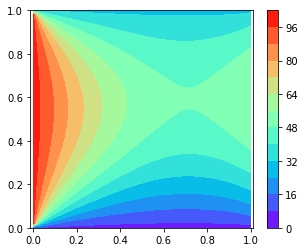

In [71]:
res=T.reshape((n_n_y,n_n_x))
X,Y=np.meshgrid(x,y)
plt.figure(figsize=(5,4))
plt.contourf(X,Y,res,12,cmap='rainbow')
plt.axis('equal')
plt.colorbar()

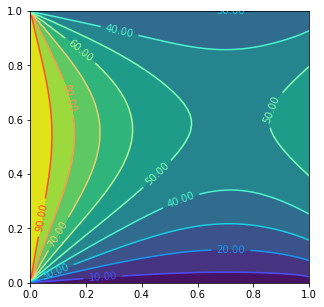

In [84]:
plt.figure(figsize=(5,5))
plt.contourf(X,Y,res,[i for i in range(0,110,10)],)
ct=plt.contour(X,Y,res,[i for i in range(0,110,10)],cmap='rainbow')
plt.clabel(ct,fmt='%.2f')
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'cmp'